In [1]:
from fastai.tabular import *

import json
import requests
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import lightgbm as lgbm

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    learning_curve,
)

In [2]:
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import re
import numpy as np

def set_plot_sizes(sml, med, big):
    plt.rc('font', size=sml)          # controls default text sizes
    plt.rc('axes', titlesize=sml)     # fontsize of the axes title
    plt.rc('axes', labelsize=med)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('legend', fontsize=sml)    # legend fontsize
    plt.rc('figure', titlesize=big)  # fontsize of the figure title

def parallel_trees(m, fn, n_jobs=8):
        return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

def draw_tree(tree, df_features, class_names, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    tree: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(tree, out_file=None, feature_names=df_features.columns, filled=True,  class_names = class_names,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

def combine_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
              seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.
    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.
    Returns:
    --------
    return value: A random sample of n rows of df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    >>> get_sample(df, 2)
       col1 col2
    1     2    b
    2     3    a
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def add_datepart(df, fldnames, drop=True, time=False, errors="raise"):	
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string or list of strings that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    >>>df2 = pd.DataFrame({'start_date' : pd.to_datetime(['3/11/2000','3/13/2000','3/15/2000']),
                            'end_date':pd.to_datetime(['3/17/2000','3/18/2000','4/1/2000'],infer_datetime_format=True)})
    >>>df2
        start_date	end_date    
    0	2000-03-11	2000-03-17
    1	2000-03-13	2000-03-18
    2	2000-03-15	2000-04-01
    >>>add_datepart(df2,['start_date','end_date'])
    >>>df2
    	start_Year	start_Month	start_Week	start_Day	start_Dayofweek	start_Dayofyear	start_Is_month_end	start_Is_month_start	start_Is_quarter_end	start_Is_quarter_start	start_Is_year_end	start_Is_year_start	start_Elapsed	end_Year	end_Month	end_Week	end_Day	end_Dayofweek	end_Dayofyear	end_Is_month_end	end_Is_month_start	end_Is_quarter_end	end_Is_quarter_start	end_Is_year_end	end_Is_year_start	end_Elapsed
    0	2000	    3	        10	        11	        5	            71	            False	            False	                False	                False	                False	            False	            952732800	    2000	    3	        11	        17	    4	            77	            False	            False	            False	            False	                False	        False	            953251200
    1	2000	    3	        11	        13	        0	            73	            False	            False	                False	                False               	False           	False           	952905600     	2000       	3	        11      	18  	5           	78          	False	            False           	False           	False               	False          	False           	953337600
    2	2000	    3	        11	        15	        2           	75          	False           	False               	False               	False               	False               False           	953078400      	2000    	4          	13      	1   	5           	92          	False           	True            	False           	True                	False          	False           	954547200
    """
    if isinstance(fldnames,str): 
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64

        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ay$|[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)

def is_date(x):
  return np.issubdtype(x.dtype, np.datetime64)

def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.
    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category {a : 1, b : 2}
    >>> df2 = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['b', 'a', 'a']})
    >>> apply_cats(df2, df)
           col1 col2
        0     1    b
        1     2    a
        2     3    a
    now the type of col is category {a : 1, b : 2}
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    ignore_flds: A list of fields that are ignored during processing.
    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

def get_nn_mappers(df, cat_vars, contin_vars):
    # Replace nulls with 0 for continuous, "" for categorical.
    for v in contin_vars: df[v] = df[v].fillna(df[v].max()+100,)
    for v in cat_vars: df[v].fillna('#NA#', inplace=True)

    # list of tuples, containing variable and instance of a transformer for that variable
    # for categoricals, use LabelEncoder to map to integers. For continuous, standardize
    cat_maps = [(o, LabelEncoder()) for o in cat_vars]
    contin_maps = [([o], StandardScaler()) for o in contin_vars]


In [8]:
class DataProcesser(BaseEstimator, TransformerMixin):
    def __init__(self, steps=["preprocess", "process"]):
        self.steps = steps

    def process_data(self, X, verbose=0):

        proc_X = X.copy()
        steps = self.steps
        proc_X = add_features(proc_X)
        
        if "preprocess" in steps:
            proc_X = self.preprocess(proc_X, verbose)
        if "process" in steps:
            proc_X = self.process(proc_X, verbose)

        return proc_X

    def preprocess(self, df: pd.DataFrame, verbose=0):
        """
        First preprocess step over a dataframe.
        Changes: include date features and map strings to categoricals.
        Return processed dataframe and a dictionary mapper of column types.
        """
        if verbose:
            logging.info(f"preprocessing dataframe columns...")
        
        date_fields = df.select_dtypes(include=["datetime64"]).columns.to_list()
        if date_fields:
            add_datepart(
                df, fldnames=date_fields
            )
        
        train_cats(df)
        
        dtype_dict = dict()
        dtype_dict["num_cols"] = df.select_dtypes(include="number").columns.to_list()
        dtype_dict["cat_cols"] = df.select_dtypes(include="category").columns.to_list()
        dtype_dict["bool_cols"] = df.select_dtypes(include="bool").columns.to_list()
        all_cols = [item for sublist in dtype_dict.values() for item in sublist]
        assert set(all_cols) == set(df.columns)

        return df

    def process(self, df: pd.DataFrame, verbose=0):
        """
        Process step over a dataframe using proc_df of fast.ai library. 
        Changes every non-numeric column to numeric using codes.
        Note that it include metrics on null values using dataset info, so it is important to split data first.
        """
        if verbose:
            logging.warning(
                "processing X...make sure you've split dataset first since I'll use dataset metrics to fill null values."
            )
        df, _, _ = proc_df(df)

        return df

    def fit(self, X, y=None, verbose=0):
        return self

    def transform(self, X, y=None, verbose=0):
        """transform data, processing each row on dataframe X. y is not used and is there just for compatibility."""
        return self.process_data(X, verbose=verbose)
    
import re
def add_features(_df):
    df = _df.copy()
    df["avg_humanas"] = df[["NOTA_DE", "NOTA_EM", "NOTA_GO", "INGLES"]].mean(axis=1)
    df["reprovacoes_total"] = df[["REPROVACOES_DE", "REPROVACOES_EM", "REPROVACOES_MF", "REPROVACOES_GO"]].mean(axis=1)
    df["study_volume"] = df["H_AULA_PRES"] * df["TAREFAS_ONLINE"]
    
    
    return df

In [9]:
df_data_1 = pd.read_csv("../Data/dataset_desafio_2.csv")
df_data_1.head()

,MATRICULA,NOME,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS,PERFIL
0,502375,Márcia Illiglener,0,0,0,0,6.2,5.8,4.6,5.9,0.0,2,4,3,EXATAS
1,397093,Jason Jytereoman Izoimum,0,0,0,0,6.0,6.2,5.2,4.5,1.0,2,4,3,EXATAS
2,915288,Bartolomeu Inácio da Gama,0,0,0,0,7.3,6.7,7.1,7.2,0.0,5,0,3,HUMANAS
3,192652,Fernanda Guedes,1,3,1,1,0.0,0.0,0.0,0.0,1.0,4,4,4,DIFICULDADE
4,949491,Alessandre Borba Gomes,1,3,1,1,0.0,0.0,0.0,0.0,1.0,5,2,5,DIFICULDADE


In [10]:
# Definição das colunas que serão features (nota-se que a coluna NOME não está presente)
features = [
    "MATRICULA", "NOME", 'REPROVACOES_DE', 'REPROVACOES_EM', "REPROVACOES_MF", "REPROVACOES_GO",
    "NOTA_DE", "NOTA_EM", "NOTA_MF", "NOTA_GO",
    "INGLES", "H_AULA_PRES", "TAREFAS_ONLINE", "FALTAS", 
]

# Definição da variável-alvo
target = ["PERFIL"]

# Preparação dos argumentos para os métodos da biblioteca ``scikit-learn``
X = df_data_1[features]
y = df_data_1[target]

# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=337)

assert set(features + target) == set(df_data_1.columns), "check your columns!!"

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
MATRICULA         20000 non-null int64
NOME              20000 non-null object
REPROVACOES_DE    20000 non-null int64
REPROVACOES_EM    20000 non-null int64
REPROVACOES_MF    20000 non-null int64
REPROVACOES_GO    20000 non-null int64
NOTA_DE           20000 non-null float64
NOTA_EM           20000 non-null float64
NOTA_MF           20000 non-null float64
NOTA_GO           16284 non-null float64
INGLES            16372 non-null float64
H_AULA_PRES       20000 non-null int64
TAREFAS_ONLINE    20000 non-null int64
FALTAS            20000 non-null int64
dtypes: float64(5), int64(8), object(1)
memory usage: 2.1+ MB


In [12]:
processer = DataProcesser()

X_proc_train = processer.fit_transform(X_train)
X_proc_train.head()

,MATRICULA,NOME,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS,avg_humanas,reprovacoes_total,study_volume,NOTA_GO_na,INGLES_na
15979,373711,4899,0,0,0,0,5.6,5.3,5.5,5.4,1.0,2,3,5,5.450000,0.0,6,True,True
7847,581227,215,1,1,1,1,0.0,0.0,0.0,0.0,1.0,3,2,3,0.250000,1.0,6,False,False
16536,663504,912,0,0,0,0,4.5,5.6,5.2,4.8,1.0,4,1,6,3.975000,0.0,4,False,False
8589,647585,1798,0,0,0,0,6.1,4.7,4.5,5.6,1.0,6,5,3,5.466667,0.0,30,False,True
19964,812616,1728,0,0,0,0,6.5,6.2,6.5,5.4,1.0,5,2,3,4.566667,0.0,10,True,False


Temos 15 colunas presentes no dataset fornecido, sendo dezessete delas variáveis características (dados de entrada) e um delas uma variável-alvo (que queremos que o nosso modelo seja capaz de prever). 

As variáveis características são:

    MATRICULA       - número de matrícula do estudante
    NOME            - nome completo do estudante
    REPROVACOES_DE  - número de reprovações na disciplina de ``Direito Empresarial``
    REPROVACOES_EM  - número de reprovações na disciplina de ``Empreendedorismo``
    REPROVACOES_MF  - número de reprovações na disciplina de ``Matemática Financeira``
    REPROVACOES_GO  - número de reprovações na disciplina de ``Gestão Operacional``
    NOTA_DE         - média simples das notas do aluno na disciplina de ``Direito Empresarial`` (0-10)
    NOTA_EM         - média simples das notas do aluno na disciplina de ``Empreendedorismo`` (0-10)
    NOTA_MF         - média simples das notas do aluno na disciplina de ``Matemática Financeira`` (0-10)
    NOTA_GO         - média simples das notas do aluno na disciplina de ``Gestão Operacional`` (0-10)
    INGLES          - variável binária que indica se o estudante tem conhecimento em língua inglesa (0 -> sim ou 1 -> não).
    H_AULA_PRES     - horas de estudo presencial realizadas pelo estudante
    TAREFAS_ONLINE  - número de tarefas online entregues pelo estudante
    FALTAS          - número de faltas acumuladas do estudante (todas disciplinas)
    
A variável-alvo é:

    PERFIL               - uma *string* que indica uma de cinco possibilidades: 
        "EXCELENTE"      - Estudante não necessita de mentoria
        "MUITO BOM"      - Estudante não necessita de mentoria
        "HUMANAS"        - Estudante necessita de mentoria exclusivamente em matérias com conteúdo de ciências humanas
        "EXATAS"         - Estudante necessita de mentoria apenas em disciplinas com conteúdo de ciências exatas
        "DIFICULDADE"    - Estudante necessita de mentoria em duas ou mais disciplinas
        
Com um modelo capaz de classificar um estudante em uma dessas categorias, podemos automatizar parte da mentoria estudantil através de assistentes virtuais, que serão capazes de recomendar práticas de estudo e conteúdo personalizado com base nas necessidades de cada aluno.

In [13]:
X[["REPROVACOES_DE","REPROVACOES_EM"]].head().mean(axis=1)

0    0.0
1    0.0
2    0.0
3    2.0
4    2.0
dtype: float64

In [14]:
add_features(X.head())

,MATRICULA,NOME,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS,avg_humanas,reprovacoes_total,study_volume
0,502375,Márcia Illiglener,0,0,0,0,6.2,5.8,4.6,5.9,0.0,2,4,3,4.475,0.0,8
1,397093,Jason Jytereoman Izoimum,0,0,0,0,6.0,6.2,5.2,4.5,1.0,2,4,3,4.425,0.0,8
2,915288,Bartolomeu Inácio da Gama,0,0,0,0,7.3,6.7,7.1,7.2,0.0,5,0,3,5.300,0.0,0
3,192652,Fernanda Guedes,1,3,1,1,0.0,0.0,0.0,0.0,1.0,4,4,4,0.250,1.5,16
4,949491,Alessandre Borba Gomes,1,3,1,1,0.0,0.0,0.0,0.0,1.0,5,2,5,0.250,1.5,10


In [15]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        # Retornamos um novo dataframe sem as colunas indesejadas
        return data.drop(labels=self.columns, axis='columns')

### Treino

In [16]:

# Criação de uma Transform personalizada ``DropColumns``

rm_columns = DropColumns(
    columns=["NOME"]
)

clf =  lgbm.LGBMClassifier()
# clf = XGBClassifier()

pipeline = Pipeline(
    steps=[
        ('remove_cols', rm_columns),
        ('preprocesser', DataProcesser()),
        ('clf', clf),
    ]
)

In [17]:
# Inicialização da Pipeline (pré-processamento e realização do treinamento do modelo)
pipeline.fit(X_train, y_train.values.ravel())

Pipeline(memory=None,
     steps=[('remove_cols', DropColumns(columns=['NOME'])), ('preprocesser', DataProcesser(steps=['preprocess', 'process'])), ('clf', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=2...0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0))])

In [18]:
# Realização de teste cego no modelo criado
from sklearn.metrics import accuracy_score

# Acurácia alcançada pela árvore de decisão
y_pred = pipeline.predict(X_test)
print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 4)))

Acurácia: 81.17999999999999%


In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[1587,  471,    1,   52,    0],
       [ 197, 2241,    1,   15,    1],
       [   0,    6,  149,   43,   19],
       [   4,    0,   38,  867,   28],
       [   0,   63,   51,  139,   27]])

In [ ]:
## boost

In [26]:
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.utils import use_named_args
from skopt.space import Real, Integer

# The list of hyper-parameters we want to optimize
space = [
    Integer(2, 256, name="num_leaves"),
    Real(10 ** -3, 0.5, "log-uniform", name="learning_rate"),
#     Integer(3, 50, name="max_depth"),
    Integer(1, 256, name="min_child_samples"),
    Real(0.05, 1.00, name="subsample"),
    Real(0.1, 1.00, name="colsample_bytree"),
#     Integer(10,500, name="n_estimators")
]

_pipeline = Pipeline(
    steps=[
        ('remove_cols', rm_columns),
        ('preprocesser', DataProcesser()),
    ]
    )


params_names = [dim.name for dim in space]

X_proc_train = _pipeline.fit_transform(X_train)

@use_named_args(space)
def objective(**params):
    clf.set_params(**params)
    
    return -np.mean(cross_val_score(clf, X_proc_train, y_train, cv=3, n_jobs=-1,
                            scoring="accuracy"))

# do bayesian optimization

clf = XGBClassifier()

result_gp = gp_minimize(
    objective, space, random_state=42, verbose=1, n_calls=20, n_random_starts=5
)

# get best params and make the best classifier
best_params = dict(zip(params_names, result_gp.x))

best_clf = XGBClassifier(**best_params)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.1008
Function value obtained: -0.8076
Current minimum: -0.8076
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.2537
Function value obtained: -0.8130
Current minimum: -0.8130
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.3149
Function value obtained: -0.8031
Current minimum: -0.8130
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.9353
Function value obtained: -0.8108
Current minimum: -0.8130
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.7466
Function value obtained: -0.6660
Current minimum: -0.8130
Iteration No: 6 started. 

In [29]:
best_pipeline = Pipeline(
    steps=[
        ('remove_cols', rm_columns),
        ('preprocesser', DataProcesser()),
        ('clf', best_clf),
    ]
)
best_pipeline.fit(X_train, y_train.values.ravel())

y_pred = best_pipeline.predict(X_test)
print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 4)))

[07:43:23] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Acurácia: 80.93%


In [33]:
%matplotlib inline

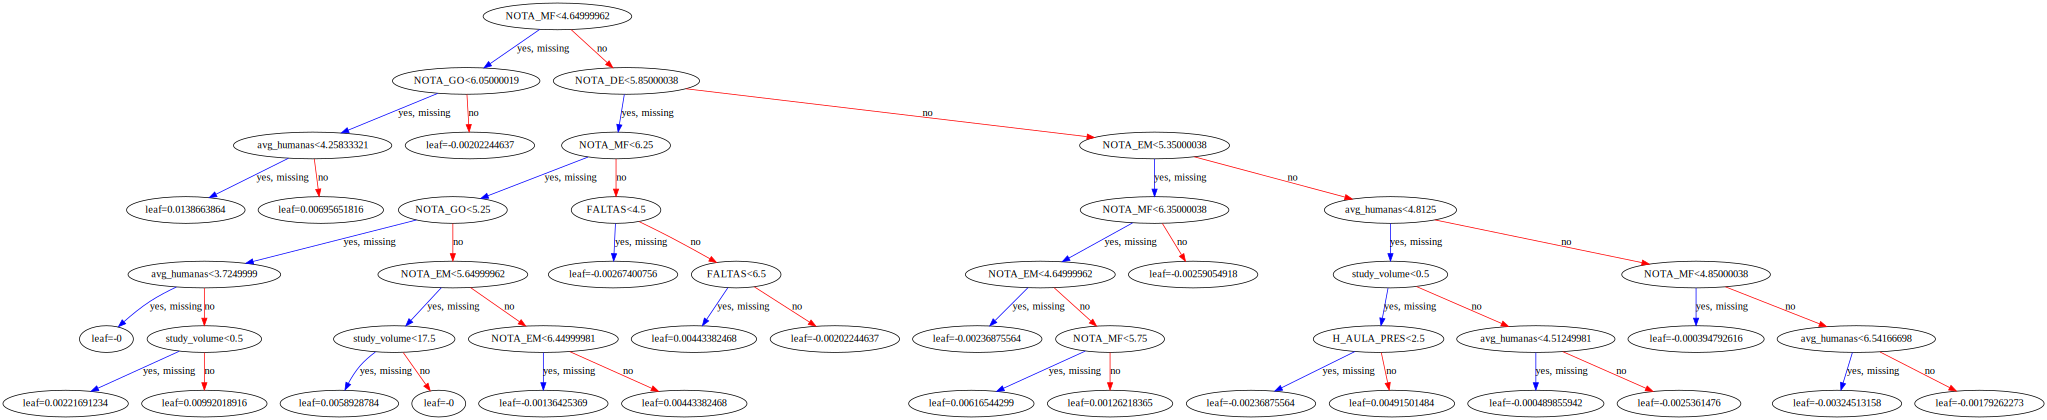

In [39]:
from xgboost import plot_tree, to_graphviz
import matplotlib.pyplot as plt

# plot_tree(best_clf, figsize=(10,10))
to_graphviz(best_clf)

# plt.show()